In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import seaborn as sns
sns.set(font_scale =1.0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
# need to install conda install python-graphviz to enable this!
import graphviz

from sklearn.model_selection import validation_curve

from xgboost import plot_tree

seed = 156

In [2]:
trainingFeaturesFilename = 'ModelInput/features.csv'
trainingLabelsFilename = 'ModelInput/labels.csv'

trainingFeatures = pd.read_csv(trainingFeaturesFilename)
trainingLabels = pd.read_csv(trainingLabelsFilename)

# For classification this isn't necessary!
#trainingFeatures['cityHasRiver'] = trainingFeatures['cityHasRiver'].astype('category')

print("Training features: {}".format(trainingFeatures.shape))
print("Training labels: {}".format(trainingLabels.shape))

#print(trainingFeatures.head())
#print(trainingFeatures.dtypes)

tempDF = pd.merge(trainingFeatures, trainingLabels, on='cityId', how='inner')
print("Combined: {}".format(tempDF.shape))

# Start at 2nd column, i.e. exclude cityId
X = pd.get_dummies(trainingFeatures.iloc[:,2:len(trainingFeatures)])
y = tempDF['cityScore'].values
print("X shape:", X.shape)
#print(type(X))
print("y:\n", y)

Training features: (128, 36)
Training labels: (128, 13)
Combined: (128, 48)
X shape: (128, 34)
y:
 [1 2 0 0 0 2 1 1 2 2 1 0 1 0 0 0 0 1 2 2 2 2 2 2 2 1 1 2 2 0 0 1 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 2 1 0 2 2 1 2 1 0 0 1 0 0 0 0 1 0 0 0 2 2 2 2 2 1 0 0
 1 0 1 0 1 0 2 2 2 2 1 2 1 1 1 0 1 0 1 0 0 2 1 2 2 1 2 1 1 1 0 1 0 1 0 0 2
 1 2 2 1 1 2 1 0 0 0 0 0 0 0 0 0 1]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
print("Train possible labels:")
print(np.unique(y_train))
print("Test possible labels:")
print(np.unique(y_test))
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Train possible labels:
[0 1 2]
Test possible labels:
[0 1 2]


In [4]:
params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'learning_rate': 0.3,
    'eta': 0.5,
    'silent': True,
    'n_estimators': 5,
    'num_class': 6
}
num_rounds = 5

In [5]:
watchlist = [(dtest, 'test'), (dtrain, 'train')]
model = xgb.train(params, dtrain, num_rounds, watchlist)
#model = XGBClassifier(**params).fit(X_train, y_train)

[0]	test-merror:0.625	train-merror:0.25
[1]	test-merror:0.59375	train-merror:0.260417
[2]	test-merror:0.65625	train-merror:0.239583
[3]	test-merror:0.59375	train-merror:0.197917
[4]	test-merror:0.5	train-merror:0.166667


In [6]:
preds = model.predict(dtest)
preds.astype('int')

array([2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 1, 2, 0,
       1, 0, 1, 2, 0, 1, 0, 0, 0, 0])

In [7]:
correct = 0

for i in range(len(preds)):
    if (y_test[i] == preds[i]):
        correct += 1

acc = accuracy_score(y_test, preds)

print('Predicated correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))

Predicated correctly: 16/32
Error: 0.5000


In [8]:
trees_dump = model.get_dump(with_stats=True)

for tree in trees_dump:
    print(tree)

0:[DesertHills<3] yes=1,no=2,missing=1,gain=5.44372177,cover=26.6666679
	1:[PlainsHillsRainforest<2] yes=3,no=4,missing=3,gain=5.26735306,cover=24.7222233
		3:[GrasslandWoods<1] yes=5,no=6,missing=5,gain=3.16788864,cover=21.3888893
			5:leaf=0.536269426,cover=9.72222233
			6:leaf=0.260526299,cover=11.666667
		4:[PlainsRainforest<2] yes=7,no=8,missing=7,gain=0.74999994,cover=3.33333349
			7:leaf=-0.112500004,cover=1.66666675
			8:leaf=0.112499997,cover=1.66666675
	2:leaf=-0.118867926,cover=1.94444454

0:[Stone<1] yes=1,no=2,missing=1,gain=3.88743496,cover=26.6666679
	1:[Grassland<1] yes=3,no=4,missing=3,gain=4.19805717,cover=18.0555573
		3:[PlainsHillsWoods<1] yes=7,no=8,missing=7,gain=3.18576479,cover=8.88888931
			7:leaf=0.309374988,cover=6.11111164
			8:leaf=-0.0529411808,cover=2.77777791
		4:[Desert<1] yes=9,no=10,missing=9,gain=2.43262935,cover=9.16666698
			9:leaf=-0.157342657,cover=6.94444466
			10:leaf=0.155172408,cover=2.22222233
	2:[Bonus<1] yes=5,no=6,missing=5,gain=1.8264026

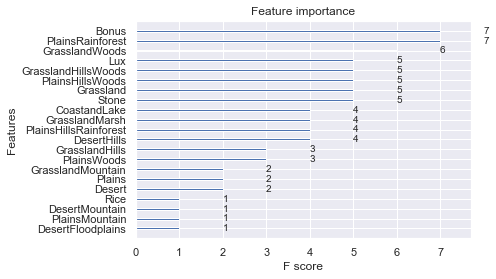

In [9]:
xgb.plot_importance(model)#, importance_type='gain', xlabel='Gain')

In [10]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [11]:
default_params = {
    'objective': 'multi:softmax',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': True,
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv = cv,
    scoring='accuracy'
)

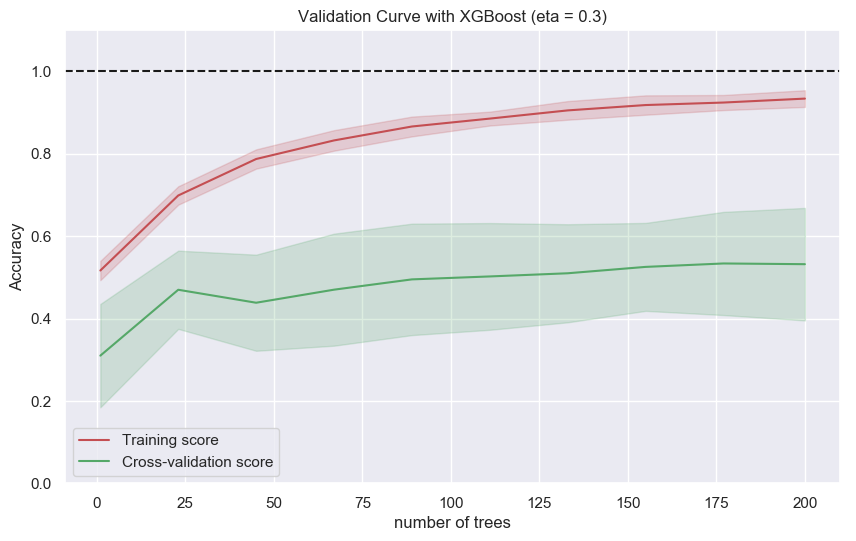

Best cross-validation result (0.53) obtained for 177 trees.


In [12]:
train_scores_mean = np.mean(train_scores, axis =1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)

plt.plot(n_estimators_range,
         train_scores_mean,
         label="Training score",
         color="r")

plt.plot(n_estimators_range,
         test_scores_mean,
         label="Cross-validation score",
         color="g")

plt.fill_between(n_estimators_range,
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees.".format(test_scores_mean[i], n_estimators_range[i]))

High Variance as above:
    if model is too complex try:
        using leas features (i.e feature selection)
        using more training samples (i.e. artifically generated?)
        increasing regularization (add penalties for extra complexity)
    in XGBoost you can try to:
        reduce depth of each tree (max_depth),
        increase min_child_weight parameter,
        increase gamma parameter,
        add more randomness using subsample, colsample_bytree parameters,
        increase lambda and alpha regularization parameters
High bias:
    if model is to simply try:
        add more features (i.e. better feature engineering),
        more sophisticated model
        decrease regularization
    in XGBoost you can try it by:
        increase depth of each tree (max_depth),
        decrease min_child_weight parameter,
        decrease gamma parameterm
        decrease mabda and alpha regularizatrion parameters

tweak. Add some randomness (each tree use 70% randomly chosen samples, and 60% randomly chosen features...) Should reduce variance.
to decrease bias, (increase accuracy) try adding an extra level to each tree

In [13]:
default_params = {
    'objective': 'multi:softmax',
    'max_depth': 2,
    'learning_rate': 0.3,
    'silent': True,
    'colsample_bytree': 0.6,
    'subsample': 0.7
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv = cv,
    scoring='accuracy'
)

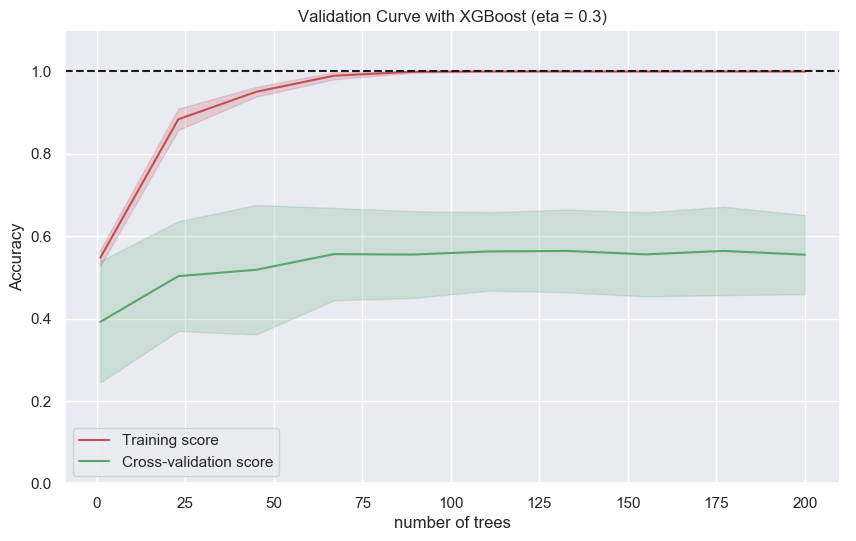

Best cross-validation result (0.56) obtained for 133 trees.


In [14]:
train_scores_mean = np.mean(train_scores, axis =1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)

plt.plot(n_estimators_range,
         train_scores_mean,
         label="Training score",
         color="r")

plt.plot(n_estimators_range,
         test_scores_mean,
         label="Cross-validation score",
         color="g")

plt.fill_between(n_estimators_range,
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees.".format(test_scores_mean[i], n_estimators_range[i]))

In [15]:
params_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [5, 10, 25, 50],
    'learning_rate': np.linspace(1e-16, 1, 3)
}
params_fixed = {
    'objective': 'multi:softmax',
    'silent': True
}

In [16]:
model_grid = GridSearchCV(
    estimator = XGBClassifier(**params_fixed, seed=seed),
    param_grid = params_grid,
    cv = cv,
    scoring='accuracy'
)
# All the scoring options are here:
# sorted(sklearn.metrics.SCORERS.keys())

In [17]:
model_grid.fit(X, y)

C:\Users\leon\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=156, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=156,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [5, 10, 25, 50], 'learning_rate': array([1.e-16, 5.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [18]:
print("Best accuracy obtained: {0}".format(model_grid.best_score_))
print("Parameters:")
for key, value in model_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.5390625
Parameters:
	learning_rate: 1.0
	max_depth: 3
	n_estimators: 50


In [19]:
params_dist_grid ={
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': [20, 21, 22, 23, 24, 25],
    'learning_rate': [1e-16, 1e-6, 1e-3, 0.1, 0.5, 0.75, 1],
    'subsample': [1e-16, 1e-3, 0.1, 0.5, 0.75, 1],
    'colsample_bytree': [1e-16, 1e-3, 0.1, 0.5, 0.75, 1]
}

In [20]:
model_rgrid = RandomizedSearchCV(
    estimator = XGBClassifier(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    random_state=seed
)

In [21]:
model_rgrid.fit(X,y)

C:\Users\leon\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=156, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=156,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [1, 2, 3, 4], 'gamma': [0, 0.5, 1], 'n_estimators': [20, 21, 22, 23, 24, 25], 'learning_rate': [1e-16, 1e-06, 0.001, 0.1, 0.5, 0.75, 1], 'subsample': [1e-16, 0.001, 0.1, 0.5, 0.75, 1], 'colsample_bytree': [1e-16, 0.001, 0.1, 0.5, 0.75, 1]},
          pre_dispatch='2*n_jobs', random_state=156, refit=True,
          return_train_score='warn', scoring='accuracy

In [22]:
print("Best accuracy obtained: {0}".format(model_rgrid.best_score_))
print("Parameters:")
for key, value in model_rgrid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.515625
Parameters:
	subsample: 0.75
	n_estimators: 23
	max_depth: 2
	learning_rate: 0.1
	gamma: 1
	colsample_bytree: 0.5


In [23]:
params = {
    'objective': 'multi:softmax',
    'max_depth': 1,
    'learning_rate': 0.1,
    'eta': 0.5,
    'silent': True,
    'num_class': 6    
}
num_rounds = 5

#    'max_depth': [1, 2, 3, 4],
#    'gamma': [0, 0.5, 1],
#    'n_estimators': [20, 21, 22, 23, 24, 25],
#    'learning_rate': [1e-16, 1e-6, 1e-3, 0.1, 0.5, 0.75, 1],
#    'subsample': [1e-16, 1e-3, 0.1, 0.5, 0.75, 1],
#    'colsample_bytree': [1e-16, 1e-3, 0.1, 0.5, 0.75, 1]


In [24]:
watchlist = [(dtest, 'test'), (dtrain, 'train')]
model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-merror:0.65625	train-merror:0.458333
[1]	test-merror:0.65625	train-merror:0.458333
[2]	test-merror:0.6875	train-merror:0.416667
[3]	test-merror:0.6875	train-merror:0.416667
[4]	test-merror:0.6875	train-merror:0.416667


In [25]:
params['eval_metric'] = ['mlogloss', 'merror']
model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-mlogloss:1.73854	test-merror:0.65625	train-mlogloss:1.71189	train-merror:0.458333
[1]	test-mlogloss:1.68824	test-merror:0.65625	train-mlogloss:1.64258	train-merror:0.458333
[2]	test-mlogloss:1.64574	test-merror:0.6875	train-mlogloss:1.58124	train-merror:0.416667
[3]	test-mlogloss:1.61124	test-merror:0.6875	train-mlogloss:1.52675	train-merror:0.416667
[4]	test-mlogloss:1.57568	test-merror:0.6875	train-mlogloss:1.47756	train-merror:0.416667


In [26]:
# custom evaluation matrix
def misclassified(pred_probs, dtrain):
    labels = dtrain.get_label() # obtain true labels
    preds = pred_probs > 0.5 # obtain predicted values
    return 'missclassified', np.sum(labels != preds)

In [27]:
model = xgb.train(params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False)

[0]	test-mlogloss:1.73854	test-merror:0.65625	train-mlogloss:1.71189	train-merror:0.458333	test-missclassified:22	train-missclassified:46
[1]	test-mlogloss:1.68824	test-merror:0.65625	train-mlogloss:1.64258	train-merror:0.458333	test-missclassified:22	train-missclassified:46
[2]	test-mlogloss:1.64574	test-merror:0.6875	train-mlogloss:1.58124	train-merror:0.416667	test-missclassified:22	train-missclassified:42
[3]	test-mlogloss:1.61124	test-merror:0.6875	train-mlogloss:1.52675	train-merror:0.416667	test-missclassified:22	train-missclassified:42
[4]	test-mlogloss:1.57568	test-merror:0.6875	train-mlogloss:1.47756	train-merror:0.416667	test-missclassified:22	train-missclassified:42


In [28]:
evals_result = {}
model = xgb.train(params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False, evals_result=evals_result)

[0]	test-mlogloss:1.73854	test-merror:0.65625	train-mlogloss:1.71189	train-merror:0.458333	test-missclassified:22	train-missclassified:46
[1]	test-mlogloss:1.68824	test-merror:0.65625	train-mlogloss:1.64258	train-merror:0.458333	test-missclassified:22	train-missclassified:46
[2]	test-mlogloss:1.64574	test-merror:0.6875	train-mlogloss:1.58124	train-merror:0.416667	test-missclassified:22	train-missclassified:42
[3]	test-mlogloss:1.61124	test-merror:0.6875	train-mlogloss:1.52675	train-merror:0.416667	test-missclassified:22	train-missclassified:42
[4]	test-mlogloss:1.57568	test-merror:0.6875	train-mlogloss:1.47756	train-merror:0.416667	test-missclassified:22	train-missclassified:42


In [29]:
print(evals_result)

{'test': {'mlogloss': [1.738543, 1.688239, 1.645744, 1.611244, 1.575684], 'merror': [0.65625, 0.65625, 0.6875, 0.6875, 0.6875], 'missclassified': [22.0, 22.0, 22.0, 22.0, 22.0]}, 'train': {'mlogloss': [1.711894, 1.642585, 1.58124, 1.526746, 1.47756], 'merror': [0.458333, 0.458333, 0.416667, 0.416667, 0.416667], 'missclassified': [46.0, 46.0, 42.0, 42.0, 42.0]}}


In [30]:
params['eval_metric'] = 'merror'
num_rounds=1500
model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

[0]	test-merror:0.65625	train-merror:0.458333
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 10 rounds.
[1]	test-merror:0.65625	train-merror:0.458333
[2]	test-merror:0.6875	train-merror:0.416667
[3]	test-merror:0.6875	train-merror:0.416667
[4]	test-merror:0.6875	train-merror:0.416667
[5]	test-merror:0.6875	train-merror:0.458333
[6]	test-merror:0.6875	train-merror:0.416667
[7]	test-merror:0.6875	train-merror:0.416667
[8]	test-merror:0.6875	train-merror:0.416667
[9]	test-merror:0.6875	train-merror:0.416667
[10]	test-merror:0.6875	train-merror:0.416667
[11]	test-merror:0.6875	train-merror:0.416667
[12]	test-merror:0.6875	train-merror:0.416667
Stopping. Best iteration:
[2]	test-merror:0.6875	train-merror:0.416667



In [31]:
print("Model best training score: {}".format(model.best_score))
print("Model best iteration: {}".format(model.best_iteration))
print("Model best number of trees limit: {}".format(model.best_ntree_limit))

Model best training score: 0.416667
Model best iteration: 2
Model best number of trees limit: 3


In [32]:
num_rounds = 10
hist = xgb.cv(params, dtrain, num_rounds, nfold=10, metrics={'merror'}, seed=seed)
hist

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.452633,0.021404,0.564445,0.100099
1,0.446819,0.015487,0.574445,0.107847
2,0.437557,0.023369,0.553334,0.094124
3,0.434095,0.026993,0.564445,0.100099
4,0.428295,0.024513,0.553334,0.094124
5,0.422494,0.018871,0.553334,0.094124
6,0.420142,0.021271,0.553334,0.094124
7,0.417870,0.018404,0.553334,0.094124
8,0.409770,0.020360,0.553334,0.094124
9,0.408607,0.020154,0.553334,0.094124


Almost exception/anomoly detection ;-)

general advice when imbalaced data:
    collect more data
    use better evaluation metric (that notices mistakes - ie AUC, FI, Kappa, ...)
    try oversampling minority class or undersampling majority class,
    generate artificial samples of minority class (ie. SMOTE)
in XGBoost:
    make sure the parameter min_child_weight is small (because leaf nodes can have smaller size groups), it is set to 1 by default
    assign more weight to specific samples while initializing DMatrix
    control the balance of positive and negative weights using set_pos_weight parameter
    use AUC for evaluation
    

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
params = {
    'objective': 'multi:softmax',
    'max_depth': 1,
    'silent': True,
    'eta': 0.5,
    'learning_rate': 0.1,
    'num_class': 4    
}
num_rounds=15

In [35]:
model = xgb.train(params, dtrain, num_rounds)
preds = model.predict(dtest)
print(preds.astype('int'))

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [36]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(preds.astype('int'), name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,9,0,9
1,8,1,9
2,13,1,14
All,30,2,32


In [37]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, preds, average='micro')))
print('Recall: {0:.2f}'.format(recall_score(y_test, preds, average='micro')))

Accuracy: 0.31
Precision: 0.31
Recall: 0.31


In [38]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 1
weights[y_train == 2] = 5
dtrain= xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test)

In [41]:
# NEED to multiclass this!!!
model = xgb.train(params, dtrain, num_rounds)
#y_test_preds = (model.predict(dtest) > 0.5).astype('int')
preds = model.predict(dtest)
print("Pred: ", preds.astype('int'))
print(" Act: ", y_test)

Pred:  [2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 1 2 1 0 1 0 0 2 2]
 Act:  [2 2 1 0 1 2 1 1 0 2 0 2 0 2 1 2 2 1 1 0 2 1 1 2 2 2 0 2 0 0 2 0]


In [42]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(preds.astype('int'), name='Predicted'),
    margins=True
)

Predicted,0,1,2,All
Actual,,,,
0,3,0,6,9
1,0,2,7,9
2,0,4,10,14
All,3,6,23,32


In [43]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, preds, average='micro')))
print('Recall: {0:.2f}'.format(recall_score(y_test, preds, average='micro')))

Accuracy: 0.47
Precision: 0.47
Recall: 0.47


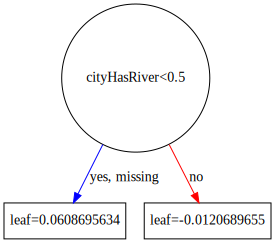

In [44]:
xgb.to_graphviz(model, num_trees=0)
#xgb.plot.tree(feature_names=X_test.columns.values, model=model, plot_width=6, plot_height=9, show_node_id=True)
#plot_tree(model, num_trees=0)
#plt.show()


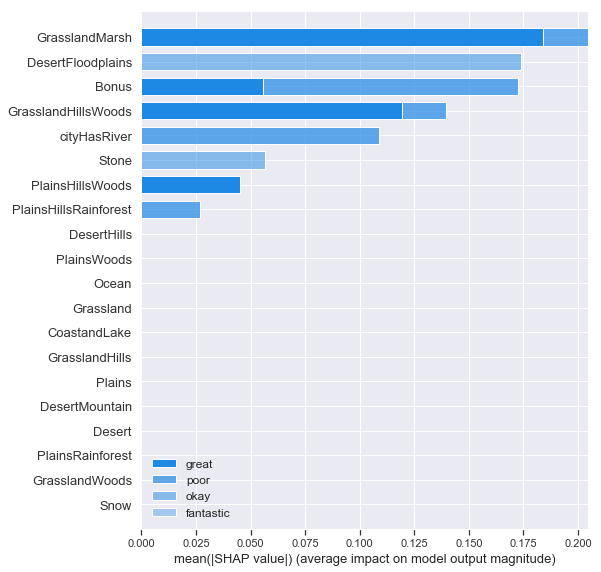

In [125]:
#conda install -c conda-forge shap
import shap

#Load JS visualisation code to Notebook
shap.initjs()

# Explain model's predictions using SHAP values
# same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

#color = lambda i: colors.default_blue_colors[min(i, len(colors.default_blue_colors)-1)]
colors = ["#FE88E5", "#ff0d57", "#13B755", "#7C52FF"]

# visualise the first prediction's explanation
#shap.force_plot(explainer.expected_value[0], shap_values[0], X)
#shap.dependence_plot("cityHasRiver", shap_values, X)
shap.summary_plot(shap_values, X, color=colors, class_names=['poor', 'okay', 'great', 'fantastic'])